# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [48]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [49]:
# point path to data
PATH = "data/bulldozers/"

In [50]:
# notice parse_dates, this is an important step when you have a 
# date column thats not already split into its constituent parts
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, 
                     parse_dates=["saledate"])

In [51]:
df_raw.SalePrice = np.log(df_raw.SalePrice)
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [52]:
# train_cats is our solution
# there is some nuance here however
# when assigning categories it is important to be consistent
# notice how this is called "train"_cats
# this is for the training set
# when you try and train your model you typically have a train and valid set
# so 'high' might be 0 in train but it could be 2 in valid
# for future reference this is why fastai has a apply_cats(df, trn)
# you can pass the data frame of the validation set as well as the 
# applied categories from the train set to achieve aforemention consistency
train_cats(df_raw)
#apply_cats(df_raw)

In [53]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [54]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [55]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [56]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200


# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [57]:
set_rf_samples(50000)

In [58]:
# the validation set is a little worse due to being all from the future
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.20649529124100546, 0.24944018378023106, 0.910884113505606, 0.8888829227135021, 0.893740027861474]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [59]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.38 s, sys: 40 ms, total: 1.42 s
Wall time: 1.43 s


(9.250535703082043, 0.2822839234241768)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [60]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 88 ms, sys: 156 ms, total: 244 ms
Wall time: 511 ms


(9.250535703082043, 0.2822839234241768)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

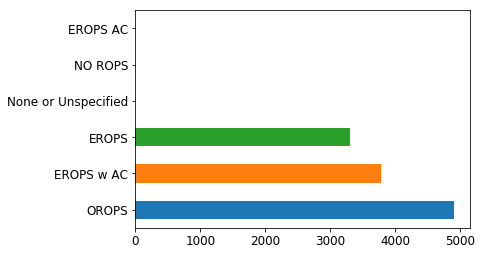

In [61]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [62]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.840480,0.278144
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.575259,0.274543
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.684958,0.218898


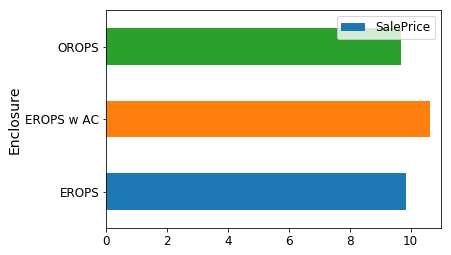

In [63]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,11));

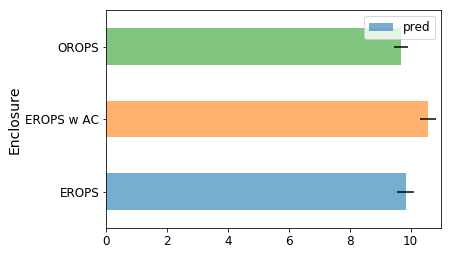

In [64]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,11));

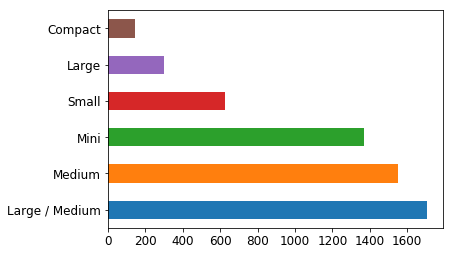

In [65]:
raw_valid.ProductSize.value_counts().plot.barh();

In [66]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.858105,0.344963
Large,10.470589,10.386889,0.351798
Large / Medium,10.691871,10.646844,0.308542
Medium,10.681511,10.614658,0.289467
Mini,9.535147,9.567300,0.252591
Small,10.324448,10.324686,0.313421


In [67]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.034993
Large             0.033869
Small             0.030356
Large / Medium    0.028980
Medium            0.027270
Mini              0.026401
dtype: float64